In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import galpy.util.coords as guc
from astropy.table import Table
#from laspec.mpl import set_cham
#set_cham(latex=False)
import gala.coordinates as gc
from astropy.coordinates import SkyCoord
import astropy.units as units
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits
import pandas as pd

In [104]:
stream_name = "Zhujiang"
dpath = f"./stream/S2808stream/" #注意文件的路径 

config_file = f"./stream/S2808stream/config_{stream_name}_mem.ini"
config = configparser.ConfigParser()
config.read(config_file)
print(config_file)


ra1 =  config["Coord_Conversion"].getfloat("ra1")
dec1 = config["Coord_Conversion"].getfloat("dec1")

ra2 = config["Coord_Conversion"].getfloat("ra2")
dec2 = config["Coord_Conversion"].getfloat("dec2")
print(ra1,dec1)
print(ra2,dec2)

./stream/S2808stream/config_Zhujiang_mem.ini
-0.5 9.0
30.0 -46.2


In [68]:
fn_pm_list = config["pm_list"]["fn_pm_list"]
data_pm_list = pd.read_csv(dpath+fn_pm_list, sep=r'\s+')

In [105]:
# ===== 手动定义两组自行范围 =====
pmra_ranges = [
    (-1.5, 0.5),   # 第一组: −1.5 < μ∗α < +0.5
    (-0.5, 1.0)    # 第二组: −0.5 < μ∗α < +1.0
]
pmdec_ranges = [
    (1.0, 2.0),    # 第一组: +1.0 < μδ < +2.0
    (0.5, 1.5)     # 第二组: +0.5 < μδ < +1.5
]
n_pm_bins = len(pmra_ranges)

In [70]:
fn_all = f"./stream/sgr member/FullSkyD10_htian_astro_pme0.2.fits"
dt = fits.open(fn_all)
data = dt[1].data
ra = data["ra"]
dec = data["dec"]
pmra = data["pmra"]
pmdec = data["pmdec"]
pm_tot = np.sqrt(pmra**2 + pmdec**2)
pmraerr = data["pmra_error"]
pmdecerr = data["pmdec_error"]
Gmag = data["phot_g_mean_mag"]
BPmag = data["phot_bp_mean_mag"]
RPmag = data["phot_rp_mean_mag"]
bb = data["b"]
ll = data["l"]

In [87]:
from sklearn.decomposition import PCA
import gala.coordinates as gc
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits


pmra_ranges = [(-1.5, -0.5), (-0.5, 1.0)]
pmdec_ranges = [(1.0, 2.0), (0.5, 1.5)]

ind_PM_all = (((pmra > pmra_ranges[0][0]) & (pmra < pmra_ranges[0][1]) & 
               (pmdec > pmdec_ranges[0][0]) & (pmdec < pmdec_ranges[0][1])) |
              ((pmra > pmra_ranges[1][0]) & (pmra < pmra_ranges[1][1]) & 
               (pmdec > pmdec_ranges[1][0]) & (pmdec < pmdec_ranges[1][1]))) 

print(f"满足自行条件的星数: {np.sum(ind_PM_all)}")

# 候选成员的坐标
ra_cand = ra[ind_PM_all]
dec_cand = dec[ind_PM_all]

coords = SkyCoord(ra=ra_cand*u.deg, dec=dec_cand*u.deg, frame='icrs')
galactic = coords.galactic
l_cand = galactic.l.deg
b_cand = galactic.b.deg

# 处理经度范围：转换到[-180, 180]
l_cand = np.where(l_cand > 180, l_cand - 360, l_cand)

满足自行条件的星数: 1311225


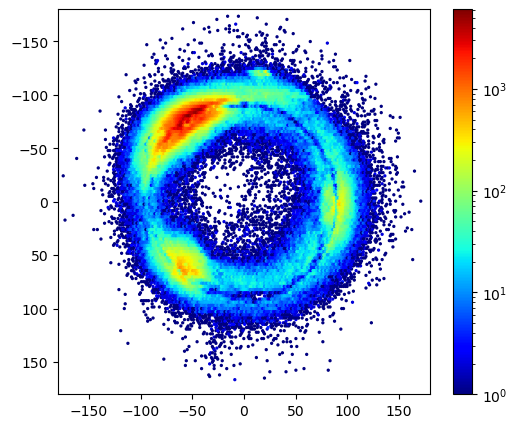

In [26]:
bins_l = np.linspace(0, 360, 360)  # 银经 0-360度
bins_b = np.linspace(-90, 90, 180)  # 银纬 -90到90度

fig = plt.figure(figsize=(6,5))
#plt.plot((90-bb[ind_PM])*np.cos(ll[ind_PM]*np.pi/180),
#         (90-bb[ind_PM])*np.sin(ll[ind_PM]*np.pi/180),
#         'k.',alpha=0.1)
#plt.plot((90-b_cand)*np.cos(l_cand*np.pi/180),
#          (90-b_cand)*np.sin(l_cand*np.pi/180),
#          'k.',alpha=0.1)
plt.hexbin((90-b_cand)*np.cos(l_cand*np.pi/180), (90-b_cand)*np.sin(l_cand*np.pi/180), gridsize=200, cmap='jet', bins='log')
plt.colorbar()


plt.xlim(-180,180)
plt.ylim([180,-180])
plt.show()

In [31]:
data_selected = data[ind_PM_all]

# 保存到新的fits文件
output_filename = "./stream/sgr member/selected_pm_candidates.fits"
hdu = fits.BinTableHDU(data=data_selected)
hdu.writeto(output_filename, overwrite=True)

print(f"已保存到: {output_filename}")
dt.close()

已保存到: ./stream/sgr member/selected_pm_candidates.fits


In [106]:
# 坐标转换到星流坐标系
endpoints = coord.SkyCoord(ra=[ra1, ra2]*u.deg, dec=[dec1, dec2]*u.deg)
frame = gc.GreatCircleICRSFrame.from_endpoints(endpoints[0], endpoints[1])
C_gaia = coord.SkyCoord(ra=ra*u.deg, dec=dec*u.deg,
                        pm_ra_cosdec=pmra*u.mas/u.yr,
                        pm_dec=pmdec*u.mas/u.yr)
CG_fr = C_gaia.transform_to(frame)
Lambda = CG_fr.phi1.deg
Beta = CG_fr.phi2.deg
coord_names = ("phi1", "phi2")

In [107]:
pmra_ranges = [
    (-1.5, -0.5),   # 第一组: −1.5 < μ∗α < -0.5
    (-0.5, 1.0)    # 第二组: −0.5 < μ∗α < +1.0
]
pmdec_ranges = [
    (1.0, 2.0),    # 第一组: +1.0 < μδ < +2.0
    (0.5, 1.5)     # 第二组: +0.5 < μδ < +1.5
]
n_pm_bins = len(pmra_ranges)

In [108]:
i_pm_bins =0
min_pmra, max_pmra = pmra_ranges[i_pm_bins][0],pmra_ranges[i_pm_bins][1]
min_pmdec, max_pmdec = pmdec_ranges[i_pm_bins][0],pmdec_ranges[i_pm_bins][1]
print(min_pmra, max_pmra)

-1.5 -0.5


In [109]:
bin_bprp = np.linspace(-1, 2.5,57)
bin_Gmag = np.linspace(13,20,71)

PM_-1.5_1.0 phi_1 is set between -50.0 and 50.0.
PM_-1.5_1.0 phi_2 is set between -3.0 and 3.0.
/tmp/ipykernel_157356/1477745201.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh((Hx[1:]+Hx[:-1])/2,(Hy[1:]+Hy[:-1])/2,np.log10(Hn.T),cmap="jet")

PM_-0.5_0.5 phi_1 is set between -50.0 and 50.0.
PM_-0.5_0.5 phi_2 is set between -3.0 and 3.0.


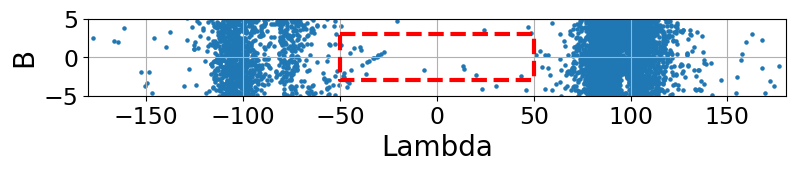

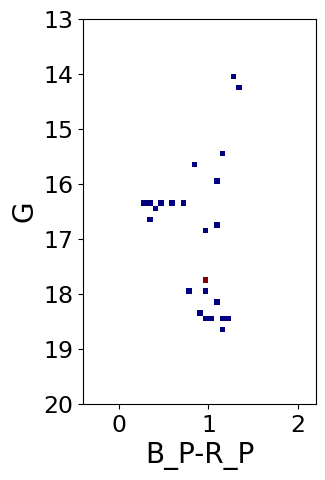

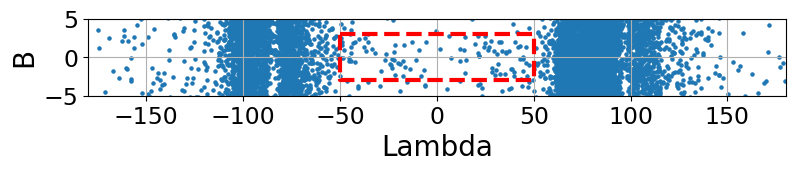

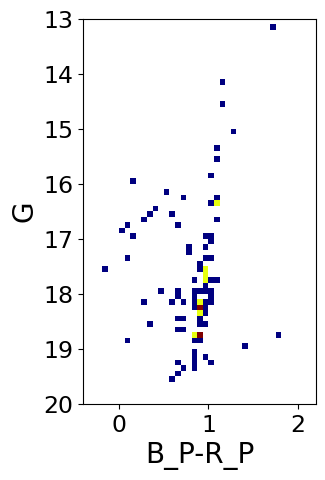

In [110]:
ra_output = np.array([])
dec_output = np.array([])
pmra_output = np.array([])
pmdec_output = np.array([])
BPmag_output = np.array([])
RPmag_output = np.array([])
Gmag_output = np.array([])
Phi1_output = np.array([])
Phi2_output = np.array([])
for i_pm_bins in range(n_pm_bins):
    min_pmra, max_pmra = pmra_ranges[i_pm_bins][0],pmra_ranges[i_pm_bins][1]
    min_pmdec, max_pmdec = pmdec_ranges[i_pm_bins][0],pmdec_ranges[i_pm_bins][1]

    min_phi1_tmp, max_phi1_tmp = -50, 50
    min_phi2_tmp, max_phi2_tmp = -3,3
    
    ind_PM = (pmra>min_pmra) & (pmra<max_pmra) & (pmdec>min_pmdec) & (pmdec<max_pmdec)

    tag = f"{min_pmra:.1f}_{min_pmdec:.1f}_S"
    
    print(f"PM_{min_pmra:.1f}_{min_pmdec:.1f} "+f"phi_1 is set between {min_phi1_tmp:.1f} and {max_phi1_tmp:.1f}.")
    print(f"PM_{min_pmra:.1f}_{min_pmdec:.1f} "+f"phi_2 is set between {min_phi2_tmp:.1f} and {max_phi2_tmp:.1f}.")
    
        
    # c = coord.ICRS(ra=ra[ind_PM]*u.degree, dec=dec[ind_PM]*u.degree)
    # sgr_tmp = c.transform_to(gc.SagittariusLaw10())
    # Lambda_tmp, Beta_tmp = sgr_tmp.Lambda.deg, sgr_tmp.Beta.deg
    Lambda_tmp = 1.0 * Lambda
    Beta_tmp = Beta * 1.0
    bin_ll = np.linspace(0,360,361)
    bin_bb = np.linspace(-90,90,181)
    #     print(np.max(Lambda_tmp),'------------')
    # else:
    #     print(f"====={longitude_shift_tmp}=====",longitude_shift_tmp)
    
    fig = plt.figure(figsize=(9,1))
    plt.scatter(Lambda_tmp[ind_PM], Beta_tmp[ind_PM],s=5)
    plt.plot([min_phi1_tmp, max_phi1_tmp, max_phi1_tmp, min_phi1_tmp, min_phi1_tmp],
            [max_phi2_tmp, max_phi2_tmp, min_phi2_tmp, min_phi2_tmp, max_phi2_tmp],
            '--', color="r", lw=3
           )
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.grid("on")
    plt.xlabel("Lambda",fontsize=20)
    plt.ylabel("B",fontsize=20)
    plt.xlim([-180,180])
    plt.ylim([-5, 5])
    #plt.savefig(plot_path+f"Sky_{tag}.png", dpi=500)

    ind_mem = (Lambda_tmp[ind_PM]>min_phi1_tmp) & (Lambda_tmp[ind_PM]<max_phi1_tmp) & (Beta_tmp[ind_PM]>min_phi2_tmp) & (Beta_tmp[ind_PM]<max_phi2_tmp) & (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5)
    Hn, Hx, Hy = np.histogram2d(BPmag[ind_PM][ind_mem]-RPmag[ind_PM][ind_mem], 
                                Gmag[ind_PM][ind_mem], 
                                bins=(bin_bprp, bin_Gmag))
    fig = plt.figure(figsize=(3,5))
    plt.pcolormesh((Hx[1:]+Hx[:-1])/2,(Hy[1:]+Hy[:-1])/2,np.log10(Hn.T),cmap="jet")
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel("B_P-R_P",fontsize=20) 
    plt.ylabel("G",fontsize=20)
    plt.xlim([-0.4, 2.2])
    plt.ylim([20,13])
    #plt.savefig(plot_path+f"CMD_{tag}.png", dpi=500)
    
    ra_output = np.append(ra_output, ra[ind_PM][ind_mem])
    dec_output = np.append(dec_output, dec[ind_PM][ind_mem])    
    pmra_output = np.append(pmra_output, pmra[ind_PM][ind_mem])
    pmdec_output = np.append(pmdec_output, pmdec[ind_PM][ind_mem])    
    
    BPmag_output = np.append(BPmag_output, BPmag[ind_PM][ind_mem])
    RPmag_output = np.append(RPmag_output, RPmag[ind_PM][ind_mem])    
    Gmag_output = np.append(Gmag_output, Gmag[ind_PM][ind_mem])    
    
    Phi1_output = np.append(Phi1_output, Lambda[ind_PM][ind_mem])
    Phi2_output = np.append(Phi2_output, Beta[ind_PM][ind_mem])
    
MemberLib = Table()
MemberLib["ra"] = ra_output
MemberLib["dec"] = dec_output
MemberLib["pmra"] = pmra_output
MemberLib["pmdec"] = pmdec_output

MemberLib["Phi1"] = Phi1_output
MemberLib["Phi2"] = Phi2_output

MemberLib["BPmag"] = BPmag_output
MemberLib["RPmag"] = RPmag_output
MemberLib["Gmag"] = Gmag_output
#MemberLib.write(dpath+f"{stream_name}_MemberLib.fits", overwrite=True)

In [111]:
len(ra_output)

123

In [64]:
Ss1 = fits.open(f"./stream/S2808stream/mem_Zhujiang.fits")
Ss1_data = Ss1[1].data
pmra = Ss1_data["pmra"]
pmdec = Ss1_data["pmdec"]

In [65]:
pm_tot = np.sqrt(pmra**2 + pmdec**2)
ind_pm_tot = (pm_tot>0.5)
pmra1 = pmra[ind_pm_tot]
len(pmra1)

165

In [114]:
# 如果两个表都有 source_id
sid1 = MemberLib["ra"]  # 假设你也有
sid2 = Ss1_data["ra"]
# 直接比较 ID
common_ids = np.intersect1d(sid1, sid2)
only_in_1 = np.setdiff1d(sid1, sid2)
only_in_2 = np.setdiff1d(sid2, sid1)
print(f"\n基于 source_id 的比较:")
print(f"共同的星: {len(common_ids)}")
print(f"只在表格1: {len(only_in_1)}")
print(f"只在表格2: {len(only_in_2)}")


基于 source_id 的比较:
共同的星: 123
只在表格1: 0
只在表格2: 42


In [115]:
# 筛选
mask_only_in_2 = np.isin(sid2, only_in_2)

# 直接用原始FITS数据创建表格（保留所有列）
extra_stars = Table(Ss1_data[mask_only_in_2])

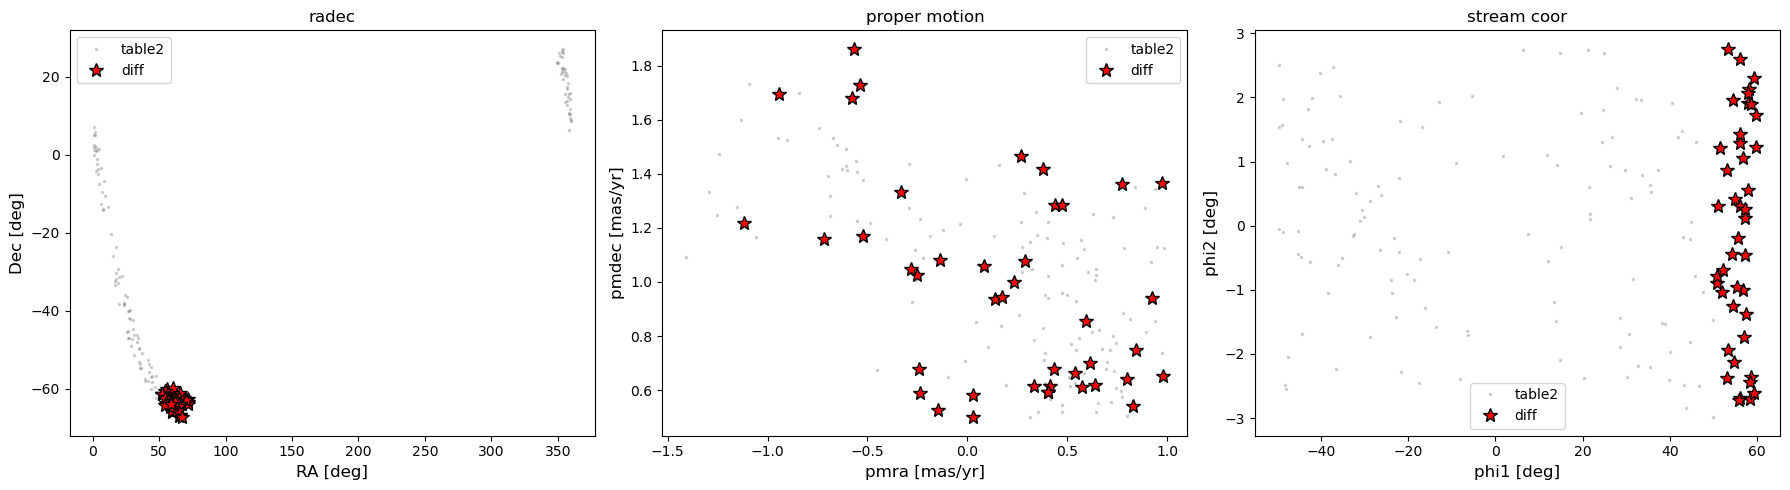

In [117]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 天球位置
ax = axes[0]
ax.plot(Ss1_data["ra"], Ss1_data["dec"], 'gray', marker='.', 
        linestyle='', alpha=0.3, label='table2', markersize=3)
ax.plot(extra_stars["ra"], extra_stars["dec"], 'r*', 
        markersize=10, label='diff', markeredgecolor='black')
ax.set_xlabel('RA [deg]', fontsize=12)
ax.set_ylabel('Dec [deg]', fontsize=12)
ax.legend()
ax.set_title('radec')

# 自行空间
ax = axes[1]
ax.plot(Ss1_data["pmra"], Ss1_data["pmdec"], 'gray', marker='.', 
        linestyle='', alpha=0.3, label='table2', markersize=3)
ax.plot(extra_stars["pmra"], extra_stars["pmdec"], 'r*', 
        markersize=10, label='diff', markeredgecolor='black')
ax.set_xlabel('pmra [mas/yr]', fontsize=12)
ax.set_ylabel('pmdec [mas/yr]', fontsize=12)
ax.legend()
ax.set_title('proper motion')

# phi1-phi2
ax = axes[2]
ax.plot(Ss1_data["phi1"], Ss1_data["phi2"], 'gray', marker='.', 
        linestyle='', alpha=0.3, label='table2', markersize=3)
ax.plot(extra_stars["phi1"], extra_stars["phi2"], 'r*', 
        markersize=10, label='diff', markeredgecolor='black')
ax.set_xlabel('phi1 [deg]', fontsize=12)
ax.set_ylabel('phi2 [deg]', fontsize=12)
ax.legend()
ax.set_title('stream coor')

plt.tight_layout()
plt.show()

In [120]:
MemberLib = Table()
MemberLib["ra"] = ra_output
MemberLib["dec"] = dec_output
MemberLib["pmra"] = pmra_output
MemberLib["pmdec"] = pmdec_output

MemberLib["Phi1"] = Phi1_output
MemberLib["Phi2"] = Phi2_output

MemberLib["BPmag"] = BPmag_output
MemberLib["RPmag"] = RPmag_output
MemberLib["Gmag"] = Gmag_output
MemberLib.write(dpath+f"zhujiang_MemberLib.fits", overwrite=True)